# End-To-End Model Driven Tutorial

In this tutorial, we will demonstrate how to use PyNNCML to perform end-to-end model-driven rainfall detection, estimation and rain field reconstruction using the OpenMRG dataset. 

The tutorial will cover the following steps:
1. Load the OpenMRG dataset [1] and plot the link data.
2. Perform wet-dry classification using statistics test and plot the results.
3. Estimate rainfall intensity using a two-steps constant baseline model and a one-step dynamic baseline model.
4. Reconstruct the rainfall field using the inverse distance weighting (IDW) and Goldshtein, Messer, Zinevich (GMZ) methods.


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/main/examples/tutorials/model_driven_tutorial.ipynb)


# Import Required Libraries 

In [1]:
import sys
import os

if os.path.exists('../../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import matplotlib as mpl
from matplotlib import pyplot as plt
from pynncml import plot_wet_dry_detection_mark


Import PyNNCML From Code


/data/envs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load OpemMRG Dataset

The OpenMRG dataset [1] is a real-world dataset that contains attenuation measurements from commercial microwave links (CMLs). <br>
The dataset contains attenuation measurements from multiple microwave links in the city of Gothenburg, Sweden, as well as ground truth rainfall data from rain gauges. <br>
Here the dataset is used to demonstrate rainfall estimation algorithms using CMLs.<br>
First, we load the dataset using PyNNCML and filter the data to a specific region and time interval. <br>

In [2]:
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
link_set, ps,_ = pnc.datasets.load_open_mrg(time_slice=time_slice, change2min_max=True)

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:33<00:00, 21.54it/s]


Second, we plot the link's measurements to visualize the attenuation measurements and CML position.

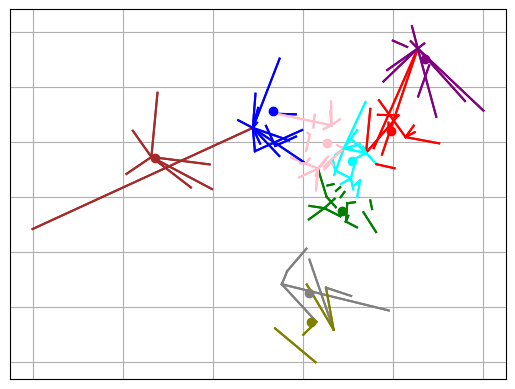

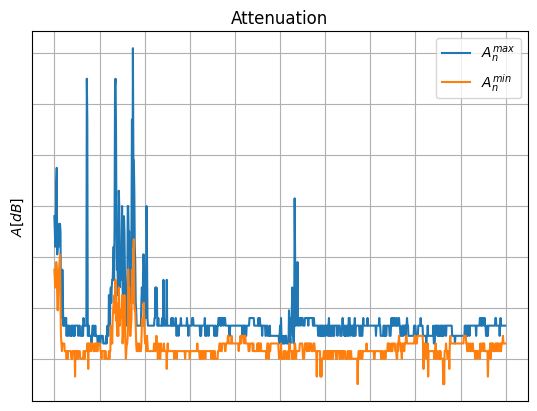

In [3]:
link_set.plot_links(scale=True, scale_factor=1,scale_y=1)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.title("")
plt.show()

link_set.get_link(0).plot()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()


# Wet-Dry classification using statistics test.
In this block, we  present  wet dry classification using statistics test, this method introduced by [2]. <br>
To classify the attenuation measurements into wet and dry events, we use a statistical test that compares the standard deviation of the attenuation measurements to a threshold value. <br>
In this method, the attenuation measurements are classified as wet if the standard deviation of the attenuation measurements is greater than a threshold value, and dry otherwise. <br>
The following figure shows a wider context, in which the Wet Dry classification is integrate inside the rain estimation flow. <br>
 ![image](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/wet_dry_location.png) <br>

Specifically, the wet-dry classification method consists of two steps: <br> 
The first step is calculating the standard deviation over a window of samples using the following equation: <br> $$\sigma_n=\Bigg[\frac{1}{|W_n|}\sum_{k \in W_n}\Big(A_k-E_{W_n}[A]\Big)^2\Bigg]^{\frac{1}{2}} $$ <br>
where $W_n$ is a moving standard deviation window in range $[n,n+N_w]$ , $A_k$ is the instance attenuation measurement of sample $k$ and $A$ is the vector of all samples and
$N_w=|W_n|$ is an hyper-parameter that set the window size.  
$$E_{W_n}[A]=\frac{1}{|W_n|}\sum_{k \in W_n}A_k $$  
Once we obtained the standard deviation vector $\sigma_n$, the following threshold function is applied:
\begin{equation}
\hat{y}^{wd}_n=\begin{cases}
1 \quad \sigma_n>\sigma_0 \\
0 \quad\text{o.w} 
\end{cases}
\end{equation} <br>
where $\hat{y}^{wd}_n=1$ is wet even and $\hat{y}^{wd}_n=0$ is dry event and $\sigma_0$ is an hyper-parameter. 

The following code block demonstrates how to perform wet-dry classification using the statistics test method and plot the results. <br>

In [4]:
# @title Statistics Wet Dry Hyper-parameters

statistics_wet_dry_threshold = 0.1  # @param{"type": "number"}
statistics_window_size = 8  # @param{"type": "integer"}

In [5]:
swd = pnc.scm.wet_dry.statistics_wet_dry(statistics_wet_dry_threshold, statistics_window_size,
                                         is_min_max=True)  # init classification model
wd_classification, std_vector = swd(link_set.get_link(0).attenuation())  # run classification method
ref = link_set.get_link(0).gauge_ref.data_array

AttributeError: 'list' object has no attribute 'data_array'

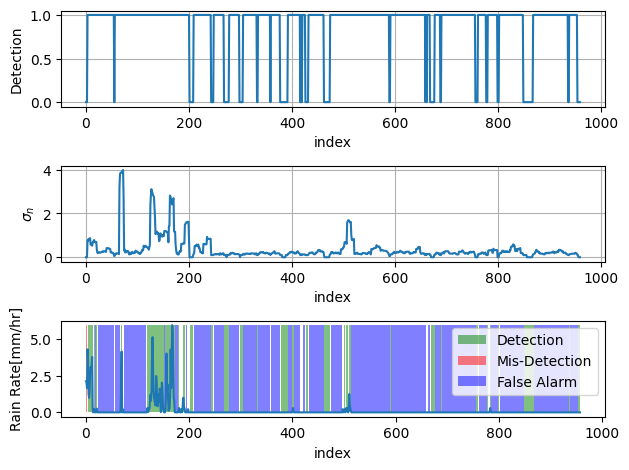

In [8]:
_, ax = plt.subplots(3, 1)
ax[0].plot(wd_classification.numpy()[0, :])
ax[0].set_xlabel('index')
ax[0].set_ylabel('Detection')
ax[0].grid()
ax[1].plot(std_vector.numpy()[0, :])
ax[1].set_xlabel('index')

ax[1].set_ylabel(r'$\sigma_n$')
ax[1].grid()
ax[2].plot(ref)
plot_wet_dry_detection_mark(ax[2], np.arange(len(ref)), wd_classification.numpy()[0, :-2], ref)
ax[2].legend()
ax[2].set_xlabel('index')
ax[2].set_ylabel(r'Rain Rate[mm/hr]')
plt.tight_layout()
plt.show()



## Rain Estimation
Here, we demonstrate how to estimate rainfall intensity using a two-steps constant baseline model and a one-step dynamic baseline model. <br>
The two-steps constant baseline model is based on the wet-dry classification results and uses a constant baseline to estimate rainfall intensity during wet events as shown in [2]. <br>
In a wider context, the two-steps constant baseline model is integrated inside the rain estimation flow as shown in the following figure. <br>
![image](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/baseline_location.png )<br>
The one-step dynamic baseline does not require wet-dry classification and uses a dynamic baseline to estimate rainfall intensity as shown in [3]. <br>

Here, we provide a short explanation of the two-steps constant baseline model and the one-step dynamic baseline model. <br>
The two-steps constant baseline model performs the following steps: <br>
1. Perform wet-dry classification using the statistics test method. <br>
2. Determine the baseline attenuation during dry events. <br>
3. Calculate the attenuation difference between the current attenuation measurements. <br>
4. Estimate the rainfall intensity using the power-law model and the attenuation difference. <br>

The one-step dynamic baseline determines the baseline attenuation as follows: <br>
 $$B_n=\min\limits_{k \in W_n}A_k $$ <br>
where $W_n$ is a moving window in range $[n,n+N_w]$ , $A_k$ is the instance attenuation measurement of sample $k$ and $N_w=|W_n|$ is an hyper-parameter that set the window size. <br>
Once we obtained the baseline attenuation $B_n$, the power-law model is applied to estimate the rain rate. <br>


In the code block below, we demonstrate how to estimate rainfall intensity using the two-steps constant baseline model and the one-step dynamic baseline model and plot the results. <br>
 




In [9]:
# @title Rain Estimation Hyper-parameters
wa_factor = 1.6  # @param{"type": "number"}
r_min = 0.3  # @param{"type": "number"}
dynamic_baseline_window_size = 4  # @param{"type": "integer"}

In [10]:
tsc = pnc.scm.rain_estimation.two_step_constant_baseline(pnc.scm.power_law.PowerLawType.MAX, r_min,
                                                         statistics_window_size, statistics_wet_dry_threshold,
                                                         wa_factor=wa_factor)
os_baseline = pnc.scm.rain_estimation.one_step_dynamic_baseline(pnc.scm.power_law.PowerLawType.MAX, r_min,
                                                                dynamic_baseline_window_size, 1)

att = link_set.get_link(0).attenuation()
rain_ts, wd, ts_baseline_res = tsc(att,
                               link_set.get_link(0).meta_data)  # run constant baseline
rain_os, os_baseline_res = os_baseline(att,
                                   link_set.get_link(0).meta_data)

Next, we plot the baseline attenuation, the CML attenuation, and the difference between the CML attenuation and the baseline attenuation. <br>
Using the two-steps constant baseline model and the one-step dynamic baseline model. <br>
The normalized attenuation is calculated as follows: 
                    $$A_{k}^{norm}=\max\Big(A_{k}-BL_k,0\Big) $$
where $A_{k}$ is the attenuation measurement at time $k$ and $BL_k$ is the baseline attenuation. <br>

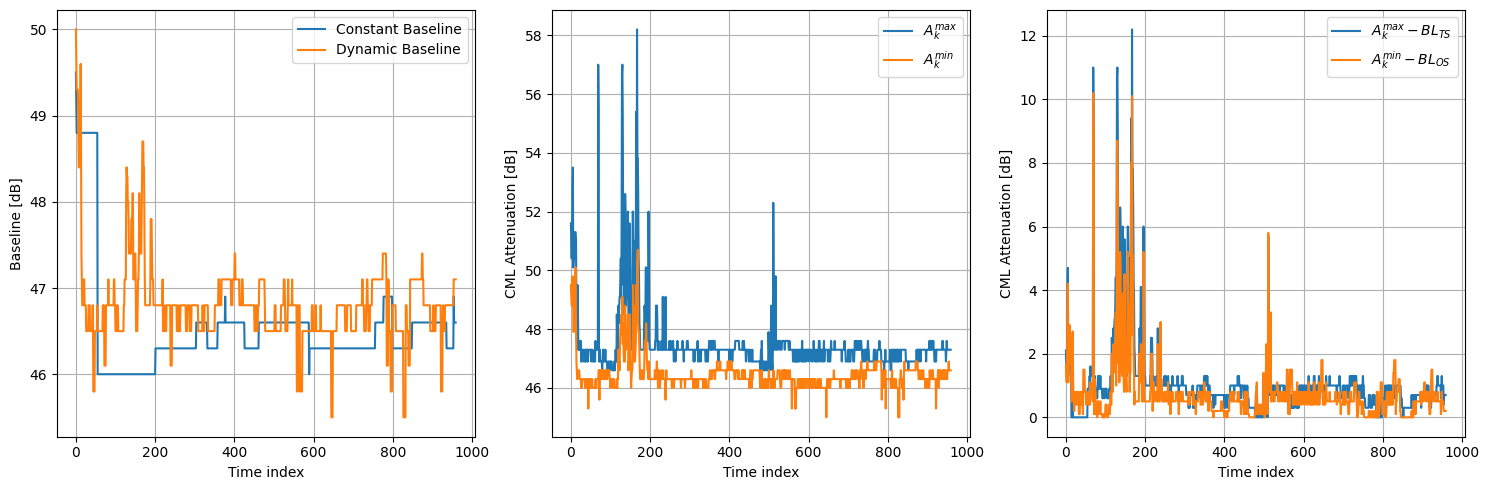

In [11]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(ts_baseline_res.numpy().flatten(), label="Constant Baseline")
axs[0].plot(os_baseline_res.numpy().flatten(), label="Dynamic Baseline")
axs[0].set_xlabel("Time index")
axs[0].set_ylabel("Baseline [dB]")
axs[0].grid()
axs[0].legend()

axs[1].plot(att[0,:,0].numpy().flatten(), label=r"$A_{k}^{max}$")
axs[1].plot(att[0,:,1].numpy().flatten(), label=r"$A_{k}^{min}$")
axs[1].set_xlabel("Time index")
axs[1].set_ylabel("CML Attenuation [dB]")
axs[1].grid()
axs[1].legend()

axs[2].plot(np.maximum(att[0,:,0].numpy().flatten()-ts_baseline_res.numpy().flatten(),0), label=r"$A_{k}^{max}-BL_{TS}$")
axs[2].plot(np.maximum(att[0,:,0].numpy().flatten()-os_baseline_res.numpy().flatten(),0), label=r"$A_{k}^{min}-BL_{OS}$")
axs[2].set_xlabel("Time index")
axs[2].set_ylabel("CML Attenuation [dB]")
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

After obtaining the normalized attenuation, we estimate the rainfall intensity using the power-law model. <br>
The power-law model is defined as follows: <br>
$$A=a\cdot R^{b}L $$ <br>
where $R$ is the rainfall intensity in mm/hr, $A$ is the normalized attenuation, and $\alpha$ and $\beta$ are the power-law parameters dependent on CML frequency and polarization. <br>
Then we extract the rain rate from the power-law model by using the following equation: <br>
$$R_k=\Bigg(\frac{A_k}{aL}\Bigg)^{\frac{1}{b}} $$ <br>

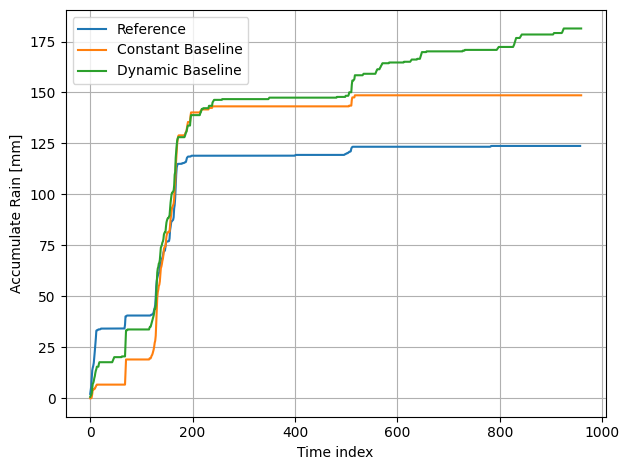

In [12]:
plt.plot(np.cumsum(ref), label="Reference")
plt.plot(np.cumsum(rain_ts), label="Constant Baseline")
plt.plot(np.cumsum(rain_os), label="Dynamic Baseline")
plt.xlabel("Time index")
plt.ylabel("Accumulate Rain [mm]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Rain Field Reconstruction
Here, we demonstrate how to reconstruct the rainfall field using the inverse distance weighting (IDW) and Goldshtein, Messer, Zinevich (GMZ) methods. <br>
First, we use the dynamic baseline model to estimate the rainfall intensity from all CMLs. <br>

In [13]:
imc = pnc.mcm.InferMultipleCMLs(os_baseline)
res = imc(link_set)

Next, we use the IDW to reconstruct the rainfall field from the estimated rainfall intensity. <br>
In the IDW method, the rainfall intensity is estimated at each grid point by averaging the rainfall intensity from the nearest CMLs. <br>
Given a set of CMLs $C$ and a grid point $g$, the rainfall intensity at grid point $g$ is estimated as follows: <br>
$$R_g=\frac{\sum_{c \in C}R_c\cdot w_c}{\sum_{c \in C}w_c}, $$ <br>
where $R_c$ is the rainfall intensity at CML $c$ and $w_c$ is the weight of CML $c$ calculated as follows: <br>
$$w_c=\frac{1}{d_c^p}, $$ <br>
where $d_c$ is the distance between CML center point $c$ and grid point $g$ and $p$ is the distance power parameter. <br>



In [14]:
# @title IDW Hyper-parameters
region_of_interest = 3  # @param{"type": "integer"}

In [15]:
idw = pnc.mcm.generate_link_set_idw(link_set, roi=region_of_interest)
rain_map = idw(res).numpy()

Finally, we use the GMZ method to reconstruct the rainfall field from the estimated rainfall intensity. <br>
In the GMZ method the algorithm takes into account the length of the link to improve the field reconstruction. <br>
![image](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/gmz_p1.png ) <br> <br>
![image](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/gmz_p2.png )<br>


In [16]:
# @title GMZ Hyper-parameters
point_per_link = 2  # @param{"type": "integer"}

In [17]:
gmz = pnc.mcm.generate_link_set_gmz(link_set, roi=region_of_interest, point_per_link=point_per_link)
rain_map_gmz, losses = gmz(res)
rain_map_gmz = rain_map_gmz.numpy()

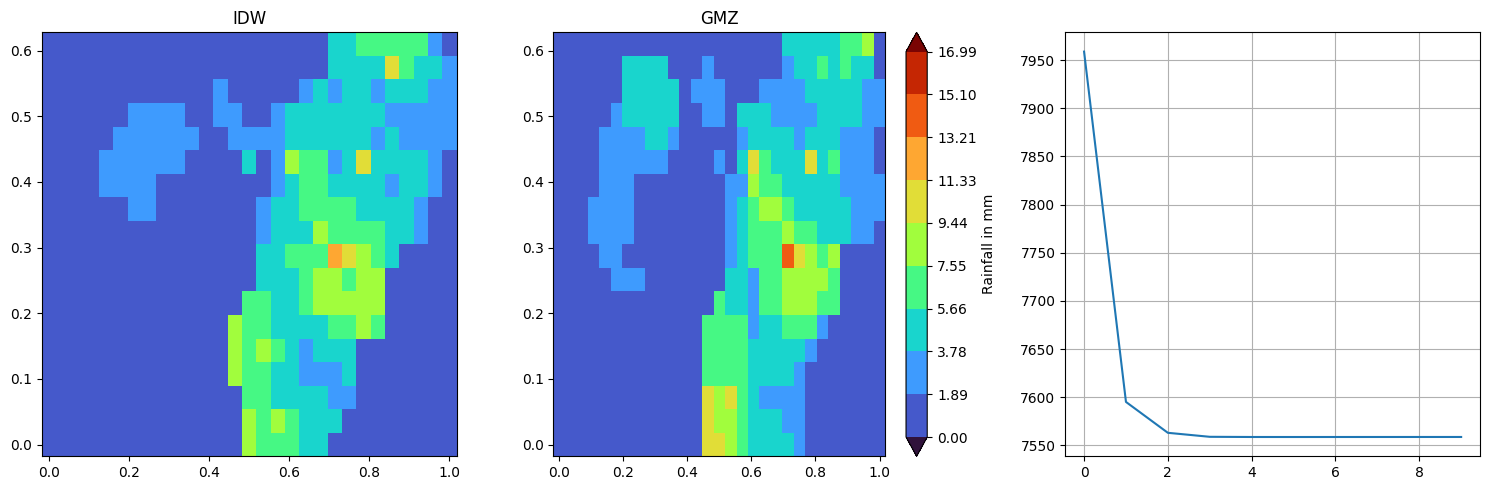

In [18]:
index = np.argmax(np.std(rain_map, axis=(1, 2)))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak_rain = np.max([np.max(rain_map), np.max(rain_map_gmz)])
bounds = np.arange(0, peak_rain, peak_rain / 10)
# bounds[0] = 1

norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

pc_zero = ax[0].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[0].set_title('IDW')
pc_one = ax[1].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map_gmz[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[1].set_title('GMZ')

ax[2].plot(losses[:, index])
ax[2].grid()
fig.colorbar(pc_one, label='Rainfall in mm')
plt.tight_layout()
plt.show()


# References

[1] van de Beek, Remco CZ, et al. OpenMRG: Open data from Microwave links, Radar, and Gauges for rainfall quantification in Gothenburg, Sweden. No. EGU23-14295. Copernicus Meetings, 2023.

[2] Marc Schleiss and Alexis Berne. Identification of dry and rainy periods using telecommunication microwave links. IEEE Geoscience and Remote Sensing Letters, 7(3):611–615, 2010

[3] J. Ostrometzky and H. Messer, “Dynamic determination of the baselinelevel in microwave links for rain monitoring from minimum attenuationvalues,”IEEE Journal of Selected Topics in Applied Earth Observationsand Remote Sensing, vol. 11, no. 1, pp. 24–33, Jan 2018.

[4] Jonatan Ostrometzky, Adam Eshel, Pinhas Alpert, and Hagit Messer. Induced bias in attenuation measurements taken from commercial microwave links. In 2017 IEEE International
Conference on Acoustics, Speech and Signal Processing (ICASSP), pages 3744–3748. IEEE,2017. <br>

[5] Goldshtein, Oren, Hagit Messer, and Artem Zinevich. "Rain rate estimation using measurements from commercial telecommunications links." IEEE Transactions on signal processing 57.4 (2009): 1616-1625.



